<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Reduced Chi^2 Notebook</b> <br>
Contact author: Brianna Smart<br>
Last verified to run: -  01/26/2023<br>
LSST Science Piplines version: - Weekly 2023_04 Large Container<br>
Container Size: Large <br># Clean Notebook

## Table of Contents

1. [Introduction](#Introduction)
2. [Conclusions](#Conclusions)
3. [Setup](#Setup)
4. [0.001 Cutoff](#0.001-Cutoff)
5. [Histogram of SdssCentroid distance from Peak Centroid](#Histogram-of-SdssCentroid-distance-from-Peak-Centroid)
6. [0.5 Cutoff](#0.5-Cutoff)
7. [1.0 Cutoff](#1.0-Cutoff)
8. [5.0 Cutoff](#5.0-Cutoff)
9. [10.0 Cutoff](#10.0-Cutoff)
10. [Reset Count Graph](#Reset-Count-Graph)

## Introduction

This notebook's purpose is to compare a number of ap_verify runs that have the maxDistToPeak for both NiaveCentroid and SdssCentroid set in the detectAndMeasure configurations. The default is -1 which means it is not run, so Sdss or Niave never get set even if they run off to unreasonable values. The first section runs with both Niave and Sdss maxDistToPeak set in terms of pixels from the peak, with values of 0.5, 5, and 10 pixels, with a 0.001 used for comparison. 

## Conclusions

At 0.5 arcseconds, base_NaiveCentroid_flag_resetToPeak occurs 410 times, with the base_SdssCentroid_flag_resetToPeak occuring 216 times. At 1.0 pixels, 262 sources are reset for the NaiveCentroid, however only 66 are reset for the SdssCentroid, with 30 sources having both centroid resets occur.  The reset counts fall of significantly for both base_SdssCentroid_flag_resetToPeak and base_NaiveCentroid_flag_resetToPeak when the maxDistanceToPeak is set to 5.0 pixels. In this case, one 1 source has both resets occur.  At 10.0, the NaiveCentroid resets 36 times and the SdssCentroid resets 16 times, with no overlapping resets. 

## Setup

In [1]:
# Basic imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
from IPython.display import Image, display

from astropy.coordinates import SkyCoord

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import ZooniverseCutoutsTask
from lsst.analysis.ap.nb_utils import make_simbad_link
from lsst.analysis.ap import apdb


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

bandList = ['i', 'z', 'y']
colorList = ['C2', 'C3', 'C5', 'k']
import lsst.afw.display as afwDisplay
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import gc

In [2]:
def m_and_v_plots (exposure, matplot=None, display_num=None):
    """
    Create an array of plots with their mask and variance

    Parameters
    ----------
    datasetRefs: a set of DataSetRefs
    returned by the butler
    matplot: Can be set to True
    display_num: Integer setting number of images

    Returns
    -------
    None
    """
    
    if display_num == None:
        display_num=1
    else:
        display_num=display_num
    
    if matplot != None:
        afwDisplay.setDefaultBackend('matplotlib') 
        
        print('Visit: ', exposure.visitInfo.getId(), ', Detector: ', exposure.detector.getId())
        fig, ax = plt.subplots(1, 3, figsize=(14, 7))
        plt.sca(ax[0])  # set the first axis as current
        plt.xlabel('Image with Mask Overlay')
        display1 = afwDisplay.Display(frame=fig)
        display1.scale('asinh', -1, 30)
        display1.mtv(exposure)
        plt.sca(ax[1])  # set the second axis as current
        display2 = afwDisplay.Display(frame=fig)
        display2.mtv(exposure.mask)
        plt.tight_layout()
        plt.sca(ax[2]) 
        display3 = afwDisplay.Display(frame=fig)
        display3.scale('asinh', 'zscale')
        display3.mtv(exposure.variance)
        plt.tight_layout()
        plt.show()
        remove_figure(fig)

    else:
        afwDisplay.setDefaultBackend('firefly')

        print('Visit: ', exposure.visitInfo.getId(), ', Detector: ',exposure.detector.getId())
        display = afwDisplay.Display(frame=0)
        display.scale('asinh', -1, 30)
        display.mtv(exposure)
        display = afwDisplay.Display(frame=1)
        display.setMaskTransparency(90)
        display.mtv(exposure.mask)
        display = afwDisplay.Display(frame=2)
        display.scale('asinh', 'zscale')
        display.mtv(exposure.variance)

In [3]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [4]:
def count_resets(sources):
    
    distance = []
    sdssResetCount = 0
    naiveResetCount = 0
    peakResetCount = 0
    overlapResetCount = 0
    
    for index, source in sources[0:500].iterrows():
        dataId ={'detector':source['detector'],'visit': source['visit'], 'instrument': source['instrument']}
        catalog = butler.get(f'deepDiff_diaSrc', dataId)
        record = catalog.find(source['diaSourceId'])
        seperation = np.sqrt((record['base_PeakCentroid_x']-record['base_SdssCentroid_x'])**(2)+(record['base_PeakCentroid_y']-record['base_SdssCentroid_y'])**(2.0))
        distance.append(seperation)
        if record['base_SdssCentroid_flag_resetToPeak']:
            sdssResetCount += 1
            peakResetCount += 1
        if record['base_NaiveCentroid_flag_resetToPeak']:
            naiveResetCount += 1
            peakResetCount += 1
        if record['base_NaiveCentroid_flag_resetToPeak'] and record['base_SdssCentroid_flag_resetToPeak']:
            overlapResetCount += 1

        
    return peakResetCount, sdssResetCount, naiveResetCount, overlapResetCount, distance

In [18]:
peakResetCount=np.zeros([5])
sdssResetCount=np.zeros([5])
naiveResetCount=np.zeros([5])
overlapResetCount=np.zeros([5])
                        
                        

## 0.001 Cutoff

This cuttoff was just for testing purposes to see if I could force all of the NaiveCentroids to reset.

In [19]:
collection="ap_verify-output/20230412T112150Z"
butler = lsst.daf.butler.Butler("/sdf/group/rubin/u/smart/workspaces/cosmos_0.001_real/repo/", collections=collection)

apdbQuery = apdb.ApdbSqliteQuery("/sdf/group/rubin/u/smart/workspaces/cosmos_0.001_real/association.db", butler=butler, instrument="HSC")
sources = apdbQuery.load_sources(exclude_flagged=True, limit=10000)

source=sources.iloc[1]
datasetType = 'calexp'

In [20]:
peakResetCount[0], sdssResetCount[0], naiveResetCount[0], overlapResetCount[0], distance = count_resets(sources)

## Histogram of SdssCentroid distance from Peak Centroid

To make the graph readable, I set the number of bins in the histogram to 100 and limited the range to 6. The actual range goes up t0 1700+, however that removes any visible structure. The second graph zooms out so the peak can be seen. The third histogram shows the full distance range.

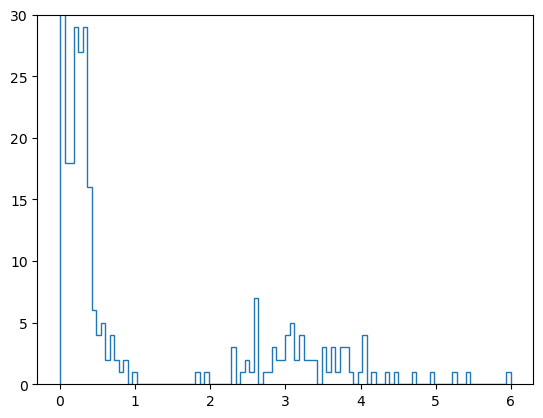

In [21]:

ax = plt.gca()
ax.set_ylim([0, 30])
counts,bins=np.histogram(distance, bins=100, range=[0,6])
plt.stairs(counts, bins)

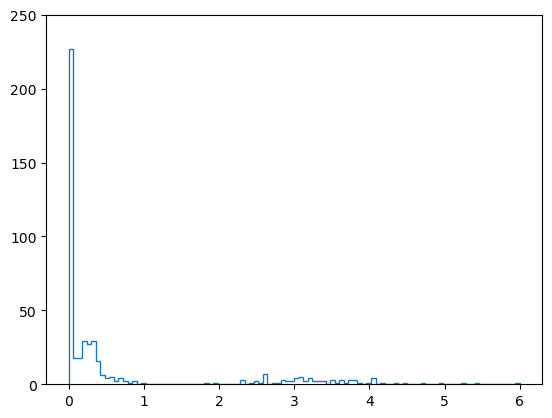

In [22]:
ax = plt.gca()
ax.set_ylim([0, 250])
counts,bins=np.histogram(distance, bins=100, range=[0,6])
plt.stairs(counts, bins)

The full range of distances without the cuttoff. Some Sdss sources get over 1700+ arcseconds away from the PeakCentroid.

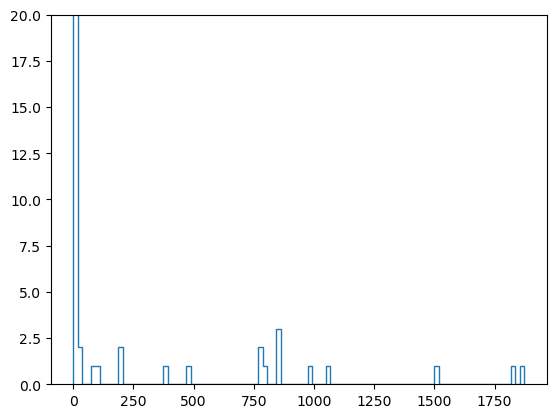

In [23]:
ax = plt.gca()
ax.set_ylim([0, 20])
counts,bins=np.histogram(distance, bins=100)
plt.stairs(counts, bins)

In [24]:
bins

array([   0.        ,   18.72586031,   37.45172062,   56.17758093,
         74.90344124,   93.62930155,  112.35516186,  131.08102217,
        149.80688248,  168.53274279,  187.25860309,  205.9844634 ,
        224.71032371,  243.43618402,  262.16204433,  280.88790464,
        299.61376495,  318.33962526,  337.06548557,  355.79134588,
        374.51720619,  393.2430665 ,  411.96892681,  430.69478712,
        449.42064743,  468.14650774,  486.87236805,  505.59822836,
        524.32408867,  543.04994897,  561.77580928,  580.50166959,
        599.2275299 ,  617.95339021,  636.67925052,  655.40511083,
        674.13097114,  692.85683145,  711.58269176,  730.30855207,
        749.03441238,  767.76027269,  786.486133  ,  805.21199331,
        823.93785362,  842.66371393,  861.38957424,  880.11543454,
        898.84129485,  917.56715516,  936.29301547,  955.01887578,
        973.74473609,  992.4705964 , 1011.19645671, 1029.92231702,
       1048.64817733, 1067.37403764, 1086.09989795, 1104.82575

## 0.5 Cutoff

In [25]:
collection="ap_verify-output/20230412T143054Z"
butler = lsst.daf.butler.Butler("/sdf/group/rubin/u/smart/workspaces/cosmos_0.5_real/repo/", collections=collection)

apdbQuery = apdb.ApdbSqliteQuery("/sdf/group/rubin/u/smart/workspaces/cosmos_0.5_real/association.db", butler=butler, instrument="HSC")
sources = apdbQuery.load_sources(exclude_flagged=True, limit=10000)

source=sources.iloc[1]
datasetType = 'calexp'

peakResetCount[1], sdssResetCount[1], naiveResetCount[1], overlapResetCount[1], distance = count_resets(sources)


## 1.0 Cutoff

In [26]:
collection="ap_verify-output/20230412T145315Z"
butler = lsst.daf.butler.Butler("/sdf/group/rubin/u/smart/workspaces/cosmos_1.0_real/repo/", collections=collection)

apdbQuery = apdb.ApdbSqliteQuery("/sdf/group/rubin/u/smart/workspaces/cosmos_1.0_real/association.db", butler=butler, instrument="HSC")
sources = apdbQuery.load_sources(exclude_flagged=True, limit=10000)

source=sources.iloc[1]
datasetType = 'calexp'

peakResetCount[2], sdssResetCount[2], naiveResetCount[2], overlapResetCount[2], distance = count_resets(sources)


# 5.0 Cutoff

In [27]:
collection="ap_verify-output/20230412T151311Z"
butler = lsst.daf.butler.Butler("/sdf/group/rubin/u/smart/workspaces/cosmos_5.0_real/repo/", collections=collection)

apdbQuery = apdb.ApdbSqliteQuery("/sdf/group/rubin/u/smart/workspaces/cosmos_5.0_real/association.db", butler=butler, instrument="HSC")
sources = apdbQuery.load_sources(exclude_flagged=True, limit=10000)

source=sources.iloc[1]
datasetType = 'calexp'

peakResetCount[3], sdssResetCount[3], naiveResetCount[3], overlapResetCount[3], distance = count_resets(sources)

## 10.0 Cutoff

In [28]:
collection="ap_verify-output/20230412T153253Z"
butler = lsst.daf.butler.Butler("/sdf/group/rubin/u/smart/workspaces/cosmos_10.0_real/repo/", collections=collection)

apdbQuery = apdb.ApdbSqliteQuery("/sdf/group/rubin/u/smart/workspaces/cosmos_10.0_real/association.db", butler=butler, instrument="HSC")
sources = apdbQuery.load_sources(exclude_flagged=True, limit=10000)

source=sources.iloc[1]
datasetType = 'calexp'

peakResetCount[4], sdssResetCount[4], naiveResetCount[4], overlapResetCount[3], distance = count_resets(sources)

## Reset Count Graph

A histogram of the total resets for the dataset. The total count may be over the 500 sources due to resets occuring for both  naiveResetCount and for sdssResetCount.

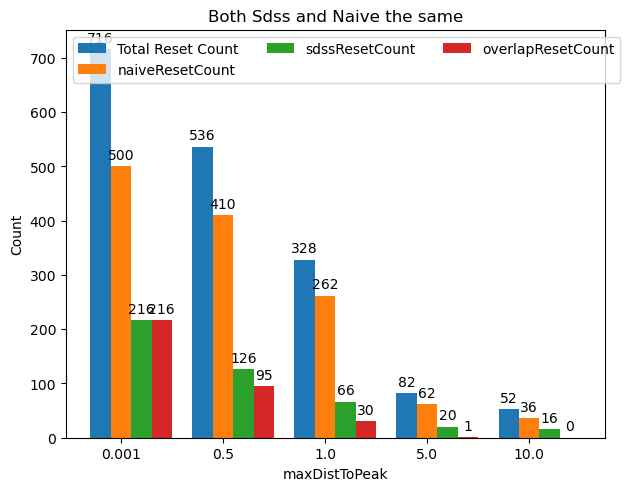

In [29]:

import matplotlib.pyplot as plt
import numpy as np

species = ("0.001", "0.5", "1.0", "5.0", "10.0")
reset = {
    'Total Reset Count': (peakResetCount),
    'naiveResetCount': (naiveResetCount),
    'sdssResetCount': (sdssResetCount),
    'overlapResetCount': (overlapResetCount),
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for item, measurement in reset.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=item)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Both Sdss and Naive the same')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_xlabel('maxDistToPeak')

plt.show()